# 欠拟合、过拟合和模型选择

在前几节基于 Fashion-MNIST 数据集的实验中，我们评价了机器学习模型在训练数据集和测试数据集上的表现。如果你改变过实验中的模型结构或者超参数，你也许发现了：当模型在训练数据集上更准确时，在测试数据集上的准确率既可能上升又可能下降。这是为什么呢？


## 训练误差和泛化误差

在解释上面提到的现象之前，我们需要区分训练误差（training error）和泛化误差（generalization error）：前者指模型在训练数据集上表现出的误差，后者指模型在任意一个测试数据样本上表现出的误差的期望。计算训练误差和泛化误差可以使用之前介绍过的损失函数，例如线性回归用到的平方损失函数和 Softmax 回归用到的交叉熵损失函数。

假设训练数据集和测试数据集里的每一个样本都是从同一个概率分布中相互独立地生成的。基于该独立同分布假设，给定任意一个机器学习模型及其参数和超参数，它的训练误差的期望和泛化误差都是一样的。然而从之前的章节中我们了解到，模型的参数并不是事先给定的，而是通过在训练数据集上训练模型而学习出的。所以，训练误差的期望小于或等于泛化误差。也就是说，通常情况下，由训练数据集学到的模型参数会使模型在训练数据集上的表现优于或等于在测试数据集上的表现。由于无法从训练误差估计泛化误差，降低训练误差并不意味着泛化误差一定会降低。我们希望通过适当降低模型的训练误差，从而能够间接降低模型的泛化误差。


## 欠拟合和过拟合

给定测试数据集，我们通常用机器学习模型在该测试数据集上的误差来反映泛化误差。当模型无法得到较低的训练误差时，我们将这一现象称作欠拟合（underfitting）。当模型的训练误差远小于它在测试数据集上的误差时，我们称该现象为过拟合（overfitting）。在实践中，我们要尽可能同时避免欠拟合和过拟合的出现。虽然有很多因素可能导致这两种拟合问题，在这里我们重点讨论两个因素：模型复杂度和训练数据集大小。


### 模型复杂度

为了解释模型复杂度，我们以多项式函数拟合为例。给定一个由标量数据特征 $x$ 和对应的标量标签 $y$ 组成的训练数据集，多项式函数拟合的目标是找一个 $K$ 阶多项式函数

$$\hat{y} = b + \sum_{k=1}^K x^k w_k$$

来近似 $y$。上式中，带下标的 $w$ 是模型的权重参数，$b$ 是偏差参数。和线性回归相同，多项式函数拟合也使用平方损失函数。特别地，一阶多项式函数拟合又叫线性函数拟合。

由于高阶多项式函数模型参数更多，模型函数的选择空间更大，所以高阶多项式函数比低阶多项式函数的复杂度更高。因此，高阶多项式函数比低阶多项式函数更容易在相同的训练数据集上得到更低的训练误差。给定训练数据集，模型复杂度和误差之间的关系通常如图 3.4 所示。给定训练数据集，如果模型的复杂度过低，很容易出现欠拟合；如果模型复杂度过高，很容易出现过拟合。

![ 模型复杂度对欠拟合和过拟合的影响 ](../img/capacity_vs_error.svg)


### 训练数据集大小

影响欠拟合和过拟合的另一个重要因素是训练数据集的大小。一般来说，如果训练数据集中样本数过少，特别是比模型参数数量更少时，过拟合更容易发生。

此外，泛化误差不会随训练数据集里样本数量增加而增大。因此，在计算资源允许范围之内，我们通常希望训练数据集大一些，特别当模型复杂度较高时，例如训练层数较多的深度学习模型时。


## 多项式函数拟合实验

为了理解模型复杂度和训练数据集大小对欠拟合和过拟合的影响，下面我们以多项式函数拟合为例来实验。首先导入实现需要的包或模块。

In [1]:
import sys
sys.path.append('..')
import gluonbook as gb
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

### 生成数据集

我们将生成一个人工数据集。在训练数据集和测试数据集中，给定样本特征 $x$，我们使用如下的三阶多项式函数来生成该样本的标签：

$$y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + \epsilon,$$

其中噪音项 $\epsilon$ 服从均值为 0 和标准差为 0.1 的正态分布。训练数据集和测试数据集的样本数都设为 100。

In [2]:
n_train = 100
n_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2),
                          nd.power(features, 3))
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

看一看生成的数据集的前 5 个样本。

In [3]:
features[:5], poly_features[:5], labels[:5]

(
 [[ 2.21220636]
  [ 0.7740038 ]
  [ 1.04344046]
  [ 1.18392551]
  [ 1.89171135]]
 <NDArray 5x1 @cpu(0)>, 
 [[  2.21220636   4.893857    10.82622147]
  [  0.7740038    0.59908187   0.46369165]
  [  1.04344046   1.08876801   1.13606453]
  [  1.18392551   1.40167964   1.65948427]
  [  1.89171135   3.5785718    6.76962519]]
 <NDArray 5x3 @cpu(0)>, 
 [ 51.6748848    6.3585763    8.94907284  11.09345436  33.03696442]
 <NDArray 5 @cpu(0)>)

### 定义、训练和测试模型

我们先定义作图函数 `semilogy`，其中 y 轴使用了对数尺度。该作图函数也被定义在 `gluonbook` 包中供后面章节调用。

In [4]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    gb.set_figsize(figsize)
    gb.plt.xlabel(x_label)
    gb.plt.ylabel(y_label)
    gb.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        gb.plt.semilogy(x2_vals, y2_vals)
        gb.plt.legend(legend)
    gb.plt.show() 

和线性回归一样，多项式函数拟合也使用平方损失函数。由于我们将尝试使用不同复杂度的模型来拟合生成的数据集，我们把模型定义部分放在 `fit_and_plot` 函数中。多项式函数拟合的训练和测试步骤与之前介绍的 Softmax 回归中的相关步骤类似。

In [5]:
num_epochs = 100
loss = gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
             range(1, num_epochs+1), test_ls, ['train', 'test'])
    return ('weight:', net[0].weight.data(), 'bias:', net[0].bias.data())

### 三阶多项式函数拟合（正常）

我们先使用与数据生成函数同阶的三阶多项式函数拟合。实验表明，这个模型的训练误差和在测试数据集的误差都较低。训练出的模型参数也接近真实值。

final epoch: train loss 0.0069609 test loss 0.0111267


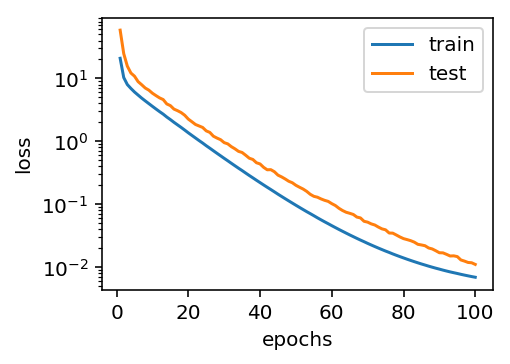

('weight:', 
 [[ 1.32370353 -3.36375189  5.56394482]]
 <NDArray 1x3 @cpu(0)>, 'bias:', 
 [ 4.95161581]
 <NDArray 1 @cpu(0)>)

In [6]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:])

### 线性函数拟合（欠拟合）

我们再试试线性函数拟合。很明显，该模型的训练误差在迭代早期下降后便很难继续降低。在完成最后一次迭代周期后，训练误差依旧很高。线性模型在非线性模型（例如三阶多项式函数）生成的数据集上容易欠拟合。

final epoch: train loss 43.9977 test loss 160.731


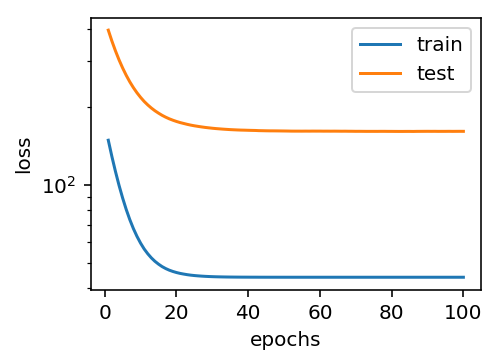

('weight:', 
 [[ 15.56569099]]
 <NDArray 1x1 @cpu(0)>, 'bias:', 
 [ 2.28597832]
 <NDArray 1 @cpu(0)>)

In [7]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

### 训练量不足（过拟合）

事实上，即便是使用与数据生成模型同阶的三阶多项式函数模型，如果训练量不足，该模型依然容易过拟合。

让我们仅仅使用两个样本来训练模型。显然，训练样本过少了，甚至少于模型参数的数量。这使模型显得过于复杂，以至于容易被训练数据中的噪音影响。在迭代过程中，即便训练误差较低，但是测试数据集上的误差却很高。这是典型的过拟合现象。

final epoch: train loss 0.402737 test loss 103.314


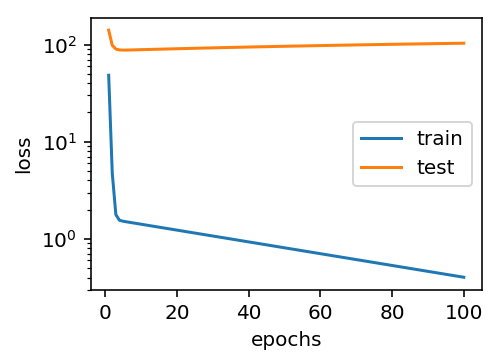

('weight:', 
 [[ 1.38723636  1.93765891  3.50859237]]
 <NDArray 1x3 @cpu(0)>, 'bias:', 
 [ 1.23128557]
 <NDArray 1 @cpu(0)>)

In [8]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

我们将在后面的章节继续讨论过拟合问题以及应对过拟合的方法，例如正则化和丢弃法。


## 模型选择

我们已经知道，训练误差无法被用来估计泛化误差。那我们是否可以根据测试数据集上的误差来调节超参数和选择模型呢？答案是否定的。原因很简单：为降低测试数据集误差而修改模型将使本节开始的“独立同分布”假设不再成立。此时测试数据集的误差无法正确反映泛化误差。

在选择模型时，我们可以切分原始训练数据集：其中大部分样本组成新的训练数据集，剩下的组成验证数据集（validation data set）。我们在新的训练数据集上训练模型，并根据模型在验证数据集上的表现调参和选择模型。最后，我们在测试数据集上评价模型的表现。


### $K$ 折交叉验证

验证模型还有很多其他的方法。其中一种常用方法叫做 $K$ 折交叉验证（$k$-fold cross-validation）。

在 K 折交叉验证中，我们把原始训练数据集分割成 $K$ 个不重合的子数据集。然后我们做 $K$ 次模型训练和验证。每一次，我们使用一个子数据集验证模型，并使用其他 $K-1$ 个子数据集来训练模型。在这 $K$ 次训练和验证中，每次用来验证模型的子数据集都不同。最后，我们只需对这 $K$ 次训练误差和验证误差分别求平均作为最终的训练误差和验证误差。

我们将在本章最后一节实验 $K$ 折交叉验证。


## 小结

* 我们希望通过适当降低模型的训练误差，从而间接降低模型的泛化误差。
* 欠拟合指模型无法得到较低的训练误差；过拟合指模型的训练误差远小于它在测试数据集上的误差。
* 我们应选择复杂度合适的模型并避免使用过少的训练样本。
* 我们要避免根据测试数据集上的误差来选择模型和调节超参数。


## 练习

* 如果用一个三阶多项式模型来拟合一个线性模型生成的数据，可能会有什么问题？为什么？
* 在我们本节提到的三阶多项式拟合问题里，有没有可能把 100 个样本的训练误差的期望降到 0，为什么？


## 扫码直达 [ 讨论区 ](https://discuss.gluon.ai/t/topic/983)

![](../img/qr_underfit-overfit.svg)